## Load packages and set up notebook

In [1]:
# module load PyTorch/1.12.1-foss-2022a-CUDA-11.7.0
# module load torchvision/0.13.1-foss-2022a-CUDA-11.7.0
# module load scikit-learn/1.2.1-gfbf-2022b
# module load matplotlib/3.7.0-gfbf-2022b
# module load Seaborn/0.12.2-foss-2022b
# module load Boost.Python-NumPy/1.79.0-foss-2022a
# module load pandas/1.1.2-foss-2020a-Python-3.8.2
# module load Pillow/9.4.0-GCCcore-12.2.0
# module load tqdm/4.64.1-GCCcore-12.2.0
# pip install scikit-multilearn
# pip install torchmetrics

In [12]:
# packages
import os
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

from PIL import Image
from sklearn.preprocessing import MultiLabelBinarizer
from skmultilearn.model_selection import iterative_train_test_split
from skmultilearn.model_selection import IterativeStratification

import torch
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as TF
import torch.nn as nn

# constants
DATA_DIR = Path('./data/')
TRAIN_DIR, TEST_DIR = DATA_DIR / 'train', DATA_DIR / 'test'
TRAIN_CSV, TEST_CSV = DATA_DIR / 'train.csv', DATA_DIR / 'submission.csv'

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
NUM_CLASSES = 10

# mean and std of image channels in the dataset
MEAN = torch.tensor([0.05409202, 0.05213123, 0.07833622])
STD = torch.tensor([0.39014456, 0.31953841, 0.36855768])

label_map = {
    0: 'Mitochondria',
    1: 'Nuclear bodies',
    2: 'Nucleoli',
    3: 'Golgi apparatus',
    4: 'Nucleoplasm',
    5: 'Nucleoli fibrillar center',
    6: 'Cytosol',
    7: 'Plasma membrane',
    8: 'Centrosome',
    9: 'Nuclear speckles',
}

# hyperparameters
RANDOM_SEED = 42
LEARNING_RATE = 0.0001
MAX_LR = 0.001
BATCH_SIZE = 128
NUM_EPOCHS = 12
WEIGHT_DECAY = 0.001
THRESHOLD = 0.4
N_SPLITS = 10

TRANSFORM_TRAIN = TF.Compose([
    TF.RandomHorizontalFlip(),
    TF.RandomVerticalFlip(),
    TF.RandomRotation(180),
    TF.RandomResizedCrop(128, scale=(0.75, 1.0), ratio=(1.0, 1.0)),
    TF.RandomCrop(128, padding=4, padding_mode='reflect'),
    TF.ToTensor(),
    TF.Normalize(mean=MEAN, std=STD),
])
TRANSFORM_TEST = TF.Compose([
    TF.ToTensor(),
    TF.Normalize(mean=MEAN, std=STD),
])

sns.set_theme()
print('Using {} device'.format(DEVICE))

Using cuda device


## Helper functions

In [3]:
def encode_label(label):
    """
    Converts a label string into a one-hot encoded tensor
    """	
    target = torch.zeros(10)
    for l in str(label).split(' '):
        target[int(l)] = 1.
    return target

def decode_target(target, text_labels=False, threshold=0.5):
    """
    Converts a one-hot encoded tensor into a label string
    """
    result = []
    for i, x in enumerate(target):
        if (int(x) >= threshold):
            if text_labels:
                result.append(label_map[i] + "(" + str(i) + ")")
            else:
                result.append(str(i))
    return ' '.join(result)

def show_sample(img, target, invert=True, threshold=0.5):
    """
    Displays a sample image and its labels
    """
    if invert:
        plt.imshow(1 - img.permute((1, 2, 0)))
    else:
        plt.imshow(img.permute(1, 2, 0))
    print('Labels:', decode_target(target, text_labels=True, threshold=threshold))

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(RANDOM_SEED)

## Load and split data

Number of labeled images: 15389 



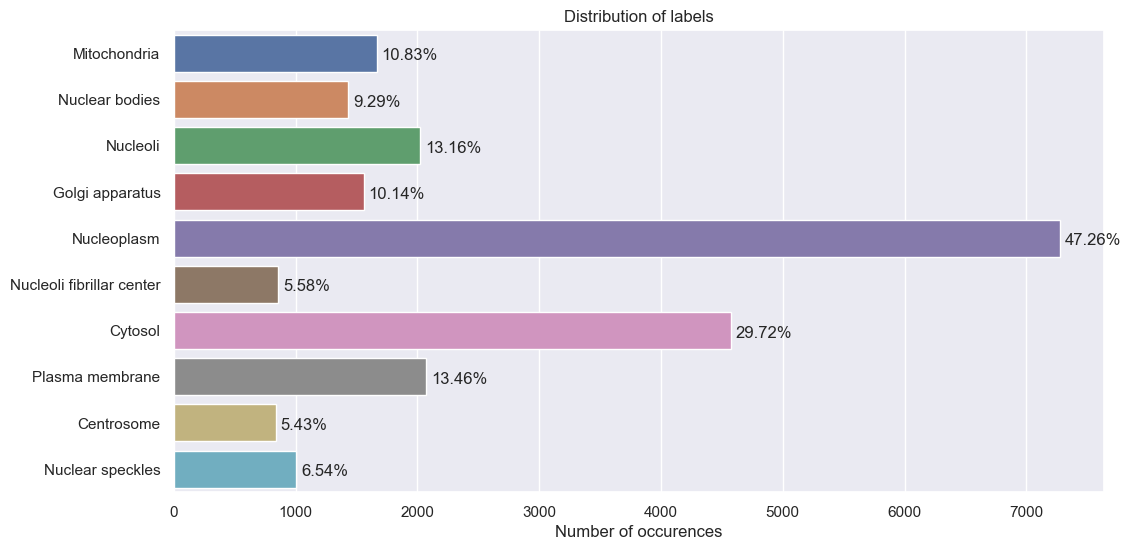

In [4]:
df = pd.read_csv(TRAIN_CSV)
print("Number of labeled images:", len(df), '\n')

# visualize class-imbalance
mlb = MultiLabelBinarizer()
counts = pd.DataFrame(
    mlb.fit_transform(df['Label'].apply(lambda x: x.split(' '))), 
    columns=mlb.classes_, index=df.index).sum()

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(
    # use label_map as x
    x=counts.values,
    y=[label_map[i] for i in range(10)],
    orient='h',
    hue=[label_map[i] for i in range(10)],
    ax=ax)
ax.set_title("Distribution of labels")
ax.set(xlabel="Number of occurences")
for i, v in enumerate(counts.values):
    ax.text(v + 40, i + .15, str(np.round(100 * v / len(df), 2)) + '%')
plt.show()

In [6]:
class HumanProteinDataset(Dataset):
    """
    Class for loading the dataset
    """
    def __init__(self, X, y, root_dir, transform=None, weight_samples=False):
        self.df = pd.DataFrame({
            'Image': X,
            'Label': [decode_target(l) for l in y]})
        self.transform = transform
        self.root_dir = root_dir
        
        if weight_samples:
            label_counts = y.sum(axis=0)
            label_weight = len(y) / (len(label_counts) * label_counts)
            label_weight = label_weight / label_weight.max()
            sample_weight = (y * label_weight).sum(axis=1) / y.sum(axis=1)
            self.sample_weights = torch.from_numpy(sample_weight)

    def __len__(self):
        return len(self.df)    
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_id, img_label = row['Image'], row['Label']
        img_fname = self.root_dir / (str(img_id) + ".png")
        img = Image.open(img_fname)
        if self.transform:
            img = self.transform(img)
        if hasattr(self, 'sample_weights'):
            return img, encode_label(img_label), self.sample_weights[idx]
        return img, encode_label(img_label)

In [7]:
def F1_score(y_pred, y_true, threshold=THRESHOLD):
    """
    Computes the macro F1 score
    """
    y_true = y_true > threshold
    y_pred = nn.Sigmoid()(y_pred) > threshold

    # compute true/false positives/negatives per sample
    TP = (y_pred & y_true).sum(1).float()
    # TN = ((~y_pred) & (~y_true)).sum(1).float()
    FP = (y_pred & (~y_true)).sum(1).float()
    FN = ((~y_pred) & y_true).sum(1).float()

    # compute precision/recall per sample and average over batch
    precision = torch.mean( TP / (TP + FP + 1e-8) )
    recall = torch.mean( TP / (TP + FN + 1e-8) )
    F = 2 * ( (precision * recall) / (precision + recall + 1e-8))

    return F.detach()


class MultilabelImageClassificationBase(nn.Module):
    """
    Base class for all models
    """
    def __init__(self):
        super().__init__()
        self.loss_fn = nn.BCEWithLogitsLoss(reduction='none')

    def training_step(self, batch, alpha):
        # unpack batch, move to GPU and make predictions
        images, targets, weights = batch
        images, targets, weights = images.to(DEVICE), targets.to(DEVICE), weights.to(DEVICE)
        out = self(images)

        # compute sample-weighted loss and macro F1 score
        loss = self.loss_fn(out, targets)
        weights_adjusted = weights * alpha + (1 - alpha)
        loss = (loss * weights_adjusted.unsqueeze(1)).mean()
        return loss

    def validation_step(self, batch):
        # unpack batch, move to GPU and make predictions
        images, targets = batch
        images, targets = images.to(DEVICE), targets.to(DEVICE)
        out = self(images)

        # compute loss and macro F1 score
        loss = self.loss_fn(out, targets)
        score = F1_score(out, targets)
        return { 'val_loss': loss.detach(), 'val_score': score.detach() }
        
    def validation_epoch_end(self, outputs):
        # compute epoch-level scores
        batch_losses, batch_scores = zip(*[(x['val_loss'], x['val_score']) for x in outputs])
        epoch_loss = torch.cat(batch_losses, dim=0).mean(0).mean()
        epoch_score = torch.stack(batch_scores).mean()
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}
    
    def epoch_end(self, epoch, result):
        # print epoch-level scores
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(
            (epoch + 1), result['train_loss'], result['val_loss'], result['val_score']))
        
        
class EfficientV2(MultilabelImageClassificationBase):
    """
    Model class based on pre-trained EfficientNetV2
    """
    def __init__(self):
        super().__init__()
        model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT)
        head = nn.Sequential(
            nn.Dropout(0.2, inplace=True),
            nn.Linear(1280, NUM_CLASSES),
            # nn.Sigmoid(),
        )
        model.classifier = head
        self.network = model
        
    def forward(self, x):
        return self.network(x)

In [8]:
def fit(epochs, lr, model, train_loader, val_loader, weight_decay=WEIGHT_DECAY):
    torch.cuda.empty_cache()
    model = model.to(DEVICE)
    history = []

    # optimizer and scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=MAX_LR, epochs=epochs, steps_per_epoch=len(train_loader))

    # Gradual transition parameters
    alphas = np.linspace(1, 0, NUM_EPOCHS)

    for epoch in range(epochs):

        alpha = alphas[epoch]

        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            optimizer.zero_grad()
            loss = model.training_step(batch, alpha)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            scheduler.step()

        # Validation phase
        model.eval()
        val_outputs = [model.validation_step(batch) for batch in val_loader]
        result = model.validation_epoch_end(val_outputs)
        result['train_loss'] = torch.stack(train_losses).mean().item()

        model.epoch_end(epoch, result)
        history.append(result)

    return history, model

def plot_history(history):
    """
    Plots the train and validation loss and validation F1 score
    """
    train_losses = [x.get('train_loss') for x in history]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    val_losses = [x['val_loss'] for x in history]
    val_scores = [x['val_score'] for x in history]

    ax1.plot(train_losses, '-bx')
    ax1.plot(val_losses, '-rx')
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')
    ax1.legend(['Training', 'Validation'])
    ax1.title.set_text('Loss vs. No. of epochs')

    ax2.plot(val_scores, '-rx')
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('F1 score')
    ax2.title.set_text('F1 score vs. No. of epochs')

    plt.show()

Training EfficientNetV2 on fold 1
Epoch [1], train_loss: 0.2508, val_loss: 0.4179, val_score: 0.0058
Training EfficientNetV2 on fold 2
Epoch [1], train_loss: 0.2560, val_loss: 0.4246, val_score: 0.0030


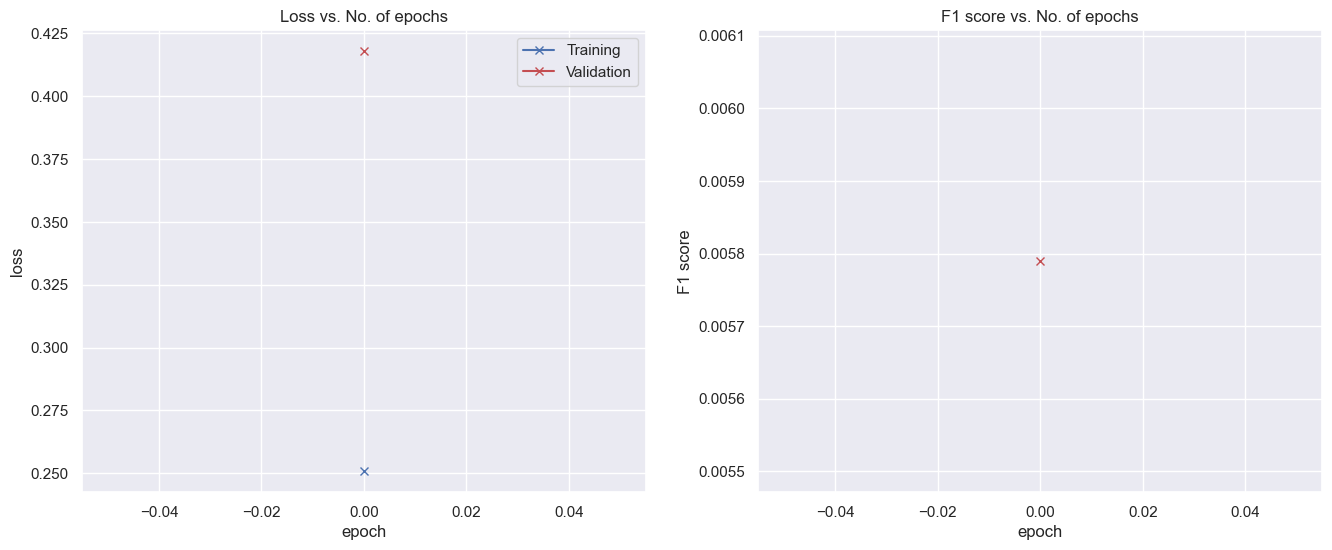

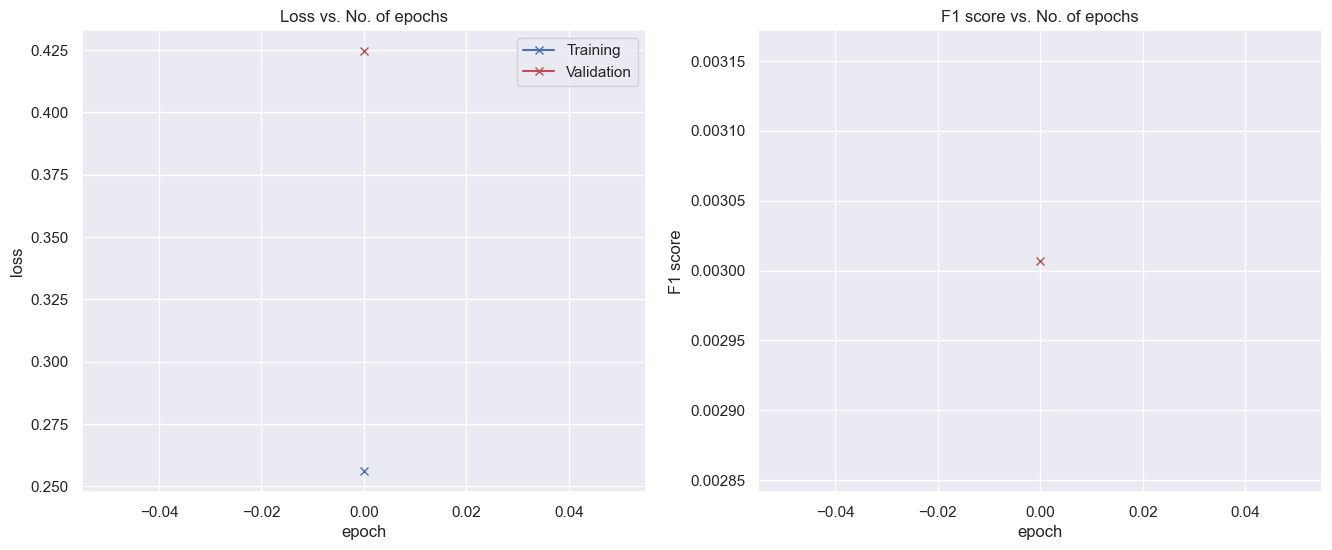

In [16]:
X = df['Image']
y = pd.DataFrame(mlb.fit_transform(df['Label'].apply(lambda x: x.split(' '))), columns=mlb.classes_, index=df.index)


# test dataloader is the same for all folds
test_df = pd.read_csv(TEST_CSV)
test_ds = HumanProteinDataset(
    X = test_df['Image'].values.reshape(-1), y = np.array([[1] + [0] * 9] * len(test_df)),
    root_dir = TEST_DIR, transform = TRANSFORM_TEST)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)
test_predictions = []


# stratified cross-validation split
strat = IterativeStratification(n_splits=N_SPLITS, order=1)
for fold, (train_idx, val_idx) in enumerate(strat.split(X.values.reshape(-1, 1), y.values)):
    # get fold split
    X_train, y_train = X.iloc[train_idx].values, y.iloc[train_idx].values
    X_val, y_val = X.iloc[val_idx].values, y.iloc[val_idx].values

    # create datasets
    train_ds = HumanProteinDataset(X_train, y_train, TRAIN_DIR, transform=TRANSFORM_TRAIN, weight_samples=True)
    valid_ds = HumanProteinDataset(X_val, y_val, TRAIN_DIR, transform=TRANSFORM_TEST)

    # create dataloaders
    train_sampler = torch.utils.data.WeightedRandomSampler(train_ds.sample_weights, len(train_ds))
    train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=train_sampler)
    valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=True)

    # create model
    model = EfficientV2()

    # train model
    print(f'Training EfficientNetV2 on fold {fold + 1}')
    history, model = fit(NUM_EPOCHS, LEARNING_RATE, model, train_dl, valid_dl)
    plot_history(history)

    # predict on test set
    model.eval()
    model_predictions = [(nn.Sigmoid()(model(X.to(DEVICE)))).detach().cpu().numpy() for X, _ in test_dl]
    test_predictions.append(np.vstack(model_predictions))

In [24]:
# average predictions over folds
test_predictions_mean = np.mean(test_predictions, axis=0)
result = [decode_target(torch.tensor(x), threshold=THRESHOLD) for x in test_predictions_mean]

# create submission file
submission_df = pd.read_csv(TEST_CSV)
submission_df["Label"] = result
submission_df.to_csv('submission.csv', index=False)

submission_df

,Image,Label
0,25880,
1,7810,
2,23748,
3,24621,
4,30169,
...,...,...
3842,7826,
3843,23761,
3844,17766,
3845,25378,


- Maybe try several thresholds and see which gives the best results score?
- Cross-validation and average the results? [here](https://www.kaggle.com/code/ronaldokun/multilabel-stratification-cv-and-ensemble)